In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
import xgboost as xgb
from lightgbm import LGBMRegressor
from scipy.stats import randint, uniform
from matplotlib.backends.backend_pdf import PdfPages

# 打印 XGBoost 和 LightGBM 版本
print(f"XGBoost version: {xgb.__version__}")

# 1. 加载数据集
dataset_path = r"D:\data\data02.csv"

# 检测文件编码
with open(dataset_path, 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']

print(f"Detected encoding: {encoding}")

# 使用检测到的编码读取文件
dataset = pd.read_csv(dataset_path, engine='python', encoding=encoding)

# 2. 数据质量检查：处理异常值或噪声
X = dataset.iloc[:, 0:11]  # 保留特征列
y = dataset.iloc[:, 11]    # 保留目标列

# 检查目标变量的异常值（例如，通过 IQR 方法）
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 移除目标变量的异常值
filtered_dataset = dataset[(y >= lower_bound) & (y <= upper_bound)]
X = filtered_dataset.iloc[:, 0:11]
y = filtered_dataset.iloc[:, 11]

# 3. 数据分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 模型训练和超参数调优
def train_model_with_tuning(model, param_grid, X_train, y_train, cv=5, n_iter=25):
    tuner = RandomizedSearchCV(model, param_grid, n_iter=n_iter, cv=cv, n_jobs=-1, random_state=42, verbose=2)
    tuner.fit(X_train, y_train)
    best_model = tuner.best_estimator_
    print(f"Best parameters: {tuner.best_params_}")
    return best_model

# 超参数网格
param_grid_lgb = {
    'n_estimators': randint(150, 250),
    'max_depth': randint(5, 8),
    'learning_rate': uniform(0.03, 0.07),
    'subsample': uniform(0.7, 0.2),
    'colsample_bytree': uniform(0.6, 0.3),
    'lambda': randint(100, 200),
    'alpha': uniform(0.5, 1.0),
    'min_child_weight': randint(10, 20)
}

param_grid_xgb = {
    'n_estimators': randint(150, 250),
    'max_depth': randint(5, 8),
    'learning_rate': uniform(0.03, 0.07),
    'subsample': uniform(0.7, 0.2),
    'colsample_bytree': uniform(0.6, 0.3),
    'lambda': randint(100, 200),
    'alpha': uniform(0.5, 1.0),
    'min_child_weight': randint(10, 20)
}

param_grid_rf = {
    'n_estimators': randint(150, 250),
    'max_depth': randint(10, 15),
    'min_samples_split': randint(3, 5),
    'min_samples_leaf': randint(2, 5)
}

# 使用 KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 训练模型
best_lgb = train_model_with_tuning(LGBMRegressor(random_state=42), param_grid_lgb, X_train, y_train, cv=kf)
best_xgb = train_model_with_tuning(xgb.XGBRegressor(objective='reg:squarederror', random_state=42), param_grid_xgb, X_train, y_train, cv=kf)
best_rf = train_model_with_tuning(RandomForestRegressor(random_state=42), param_grid_rf, X_train, y_train, cv=kf)

# 5. 模型融合：堆叠融合
lgb_preds = cross_val_predict(best_lgb, X_train, y_train, cv=kf)
xgb_preds = cross_val_predict(best_xgb, X_train, y_train, cv=kf)
rf_preds = cross_val_predict(best_rf, X_train, y_train, cv=kf)

X_train_stacked = np.column_stack((lgb_preds, xgb_preds, rf_preds))
X_test_stacked = np.column_stack((
    best_lgb.predict(X_test),
    best_xgb.predict(X_test),
    best_rf.predict(X_test)
))

stacking_model = StackingRegressor(
    estimators=[
        ('lgb', best_lgb),
        ('xgb', best_xgb),
        ('rf', best_rf)
    ],
    final_estimator=Ridge(alpha=1.0)
)

stacking_model.fit(X_train_stacked, y_train)

# 6. 特征重要性分析
def plot_feature_importances(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
    else:
        raise AttributeError("The model does not have a 'feature_importances_' attribute.")
    
    if len(feature_importances) != len(feature_names):
        raise ValueError("The lengths of feature_importances and feature_names do not match.")
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances, y=feature_names)
    plt.title("Feature Importances")
    plt.tight_layout()

# 使用原始特征名称
feature_names = X.columns.tolist()

# 7. 模型评估
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_R2 = r2_score(y_train, y_train_pred)
    test_R2 = r2_score(y_test, y_test_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    return train_R2, test_R2, train_mse, test_mse, train_rmse, test_rmse, train_mae, test_mae

# 定义一个函数来绘制预测值与实测值的散点图
def plot_predictions_vs_actual(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, label="Predictions")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--', label="Perfect Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs Actual Values for {model_name}")
    plt.legend()

# 创建 PDF 文件保存所有图片
pdf_path = r"D:\data\Results01.pdf"
os.makedirs(os.path.dirname(pdf_path), exist_ok=True)

with PdfPages(pdf_path) as pdf:
    # 保存特征重要性图
    plot_feature_importances(best_lgb, feature_names)
    pdf.savefig()
    plt.close()

    # 评估各个模型并保存预测图
    models = {
        'XGBoost': best_xgb,
        'Random Forest': best_rf,
        'LightGBM': best_lgb,
        'Stacking': stacking_model
    }

    results = {}
    for name, model in models.items():
        if name == 'Stacking':
            train_R2, test_R2, train_mse, test_mse, train_rmse, test_rmse, train_mae, test_mae = evaluate_model(model, X_train_stacked, y_train, X_test_stacked, y_test)
            y_pred = model.predict(X_test_stacked)
        else:
            train_R2, test_R2, train_mse, test_mse, train_rmse, test_rmse, train_mae, test_mae = evaluate_model(model, X_train, y_train, X_test, y_test)
            y_pred = model.predict(X_test)

        results[name] = {
            'Train R2': train_R2,
            'Test R2': test_R2,
            'Train MSE': train_mse,
            'Test MSE': test_mse,
            'Train RMSE': train_rmse,
            'Test RMSE': test_rmse,
            'Train MAE': train_mae,
            'Test MAE': test_mae
        }

        plot_predictions_vs_actual(y_test, y_pred, name)
        pdf.savefig()
        plt.close()

    # 输出评估参数
    plt.figure(figsize=(10, 6))
    plt.axis('off')
    plt.title("Model Evaluation Metrics")
    table_data = [
        ["Model", "Train R2", "Test R2", "Train MSE", "Test MSE", "Train RMSE", "Test RMSE", "Train MAE", "Test MAE"]
    ]
    for name, metrics in results.items():
        table_data.append([
            name,
            f"{metrics['Train R2']:.4f}",
            f"{metrics['Test R2']:.4f}",
            f"{metrics['Train MSE']:.4f}",
            f"{metrics['Test MSE']:.4f}",
            f"{metrics['Train RMSE']:.4f}",
            f"{metrics['Test RMSE']:.4f}",
            f"{metrics['Train MAE']:.4f}",
            f"{metrics['Test MAE']:.4f}"
        ])
    table = plt.table(cellText=table_data, loc='center', cellLoc='center', colLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    pdf.savefig()
    plt.close()

print(f"All plots and evaluation metrics have been saved to {pdf_path}")

XGBoost version: 2.1.1
Detected encoding: ISO-8859-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=101. Current value: lambda_l2=101
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=101. Current value: lambda_l2=101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 289, number of used features: 9
[LightGBM] [Info] Start training from score 637.368252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [18]:
# 导入必要的库
from scipy.stats import t
import numpy as np

# 定义一个函数来计算置信区间
def calculate_confidence_interval(y_pred, confidence_level=0.95):
    n = len(y_pred)
    mean = np.mean(y_pred)
    std_err = np.std(y_pred, ddof=1) / np.sqrt(n)
    t_value = t.ppf((1 + confidence_level) / 2, n - 1)
    margin_of_error = t_value * std_err
    return mean - margin_of_error, mean + margin_of_error

# 定义一个函数来计算多次运行方差
def calculate_variance_across_runs(model, X, y, n_runs=30):
    predictions = []
    for i in range(n_runs):
        # 使用不同的随机种子
        if hasattr(model, 'random_state'):
            model.set_params(random_state=i)
        model.fit(X, y)
        y_pred = model.predict(X)
        predictions.append(y_pred)
    predictions = np.array(predictions)
    variances = np.var(predictions, axis=0)
    return np.mean(variances)

# 计算并保存置信区间和多次运行方差
results_with_uncertainty = {}
models = {
    'XGBoost': best_xgb,
    'Random Forest': best_rf,
    'LightGBM': best_lgb
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    # 计算置信区间
    ci_lower, ci_upper = calculate_confidence_interval(y_pred)
    
    # 计算多次运行方差
    variance = calculate_variance_across_runs(model, X_train, y_train)
    
    results_with_uncertainty[name] = {
        'Confidence Interval (95%)': (ci_lower, ci_upper),
        'Variance Across Runs': variance
    }

    # 打印结果
    print(f"Model: {name}")
    print(f"Confidence Interval (95%): ({ci_lower:.4f}, {ci_upper:.4f})")
    print(f"Variance Across Runs: {variance:.4f}\n")

# 将置信区间和方差结果保存到 PDF
pdf_path = r"D:\data\Results01.pdf"

with PdfPages(pdf_path) as pdf:
    plt.figure(figsize=(10, 6))
    plt.axis('off')
    plt.title("Model Uncertainty Quantification")
    table_data = [
        ["Model", "Confidence Interval (95%)", "Variance Across Runs"]
    ]
    for name, metrics in results_with_uncertainty.items():
        table_data.append([
            name,
            f"({metrics['Confidence Interval (95%)'][0]:.4f}, {metrics['Confidence Interval (95%)'][1]:.4f})",
            f"{metrics['Variance Across Runs']:.4f}"
        ])
    table = plt.table(cellText=table_data, loc='center', cellLoc='center', colLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    pdf.savefig()
    plt.close()

print("Confidence interval and variance results have been added to the PDF.")

Model: XGBoost
Confidence Interval (95%): (642.4243, 725.3443)
Variance Across Runs: 31.2014

Model: Random Forest
Confidence Interval (95%): (625.5057, 725.8495)
Variance Across Runs: 42.8811

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=101. Current value: lambda_l2=101
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=101. Current value: lambda_l2=101
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=101. Current value: lambda_l2=101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 289, number of used features: 9
[LightGBM] [Info] Start training from score 637.368252
[LightGBM] [Warning]

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=101. Current value: lambda_l2=101
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=101. Current value: lambda_l2=101


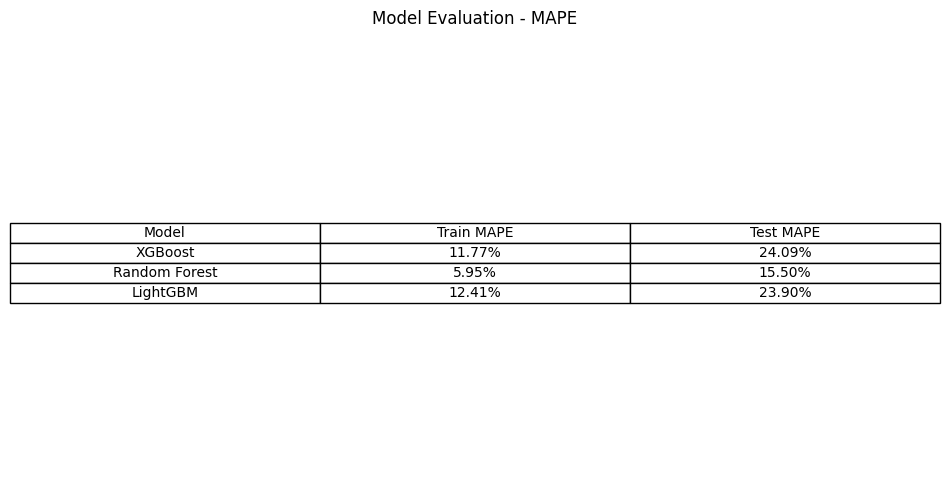

In [19]:
from sklearn.metrics import mean_absolute_error

# 更新evaluate_model函数，只返回MAPE
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # 计算MAPE
    def mape(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        # 避免除以零
        mask = y_true != 0
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    train_mape = mape(y_train, y_train_pred)
    test_mape = mape(y_test, y_test_pred)
    
    return train_mape, test_mape

# 在评估模型时，只存储MAPE结果
results = {}
for name, model in models.items():
    if name == 'Stacking':
        train_mape, test_mape = evaluate_model(model, X_train_stacked, y_train, X_test_stacked, y_test)
    else:
        train_mape, test_mape = evaluate_model(model, X_train, y_train, X_test, y_test)

    results[name] = {
        'Train MAPE': train_mape,
        'Test MAPE': test_mape
    }

# 在表格中只显示MAPE
table_data = [
    ["Model", "Train MAPE", "Test MAPE"]
]
for name, metrics in results.items():
    table_data.append([
        name,
        f"{metrics['Train MAPE']:.2f}%",
        f"{metrics['Test MAPE']:.2f}%"
    ])

# 绘制表格并保存到PDF
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.title("Model Evaluation - MAPE")
table = plt.table(cellText=table_data, loc='center', cellLoc='center', colLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

In [2]:
# 生成特征重要性表格
def generate_feature_importance_table(model, feature_names, save_path):
    # 获取特征重要性
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        feature_importances = np.abs(model.coef_)
    else:
        raise ValueError("Model does not have feature importance or coefficient attributes.")
    
    # 创建特征重要性表格
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)
    
    # 保存表格到指定路径
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    feature_importance_df.to_csv(save_path, index=False)
    print(f"Feature importance table has been saved to {save_path}")

# 特征名称（根据实际情况调整）
feature_names = X.columns.tolist()

# 保存特征重要性表格的路径
save_path = r"D:\data\FI\feature_importance.csv"

# 生成并保存特征重要性表格
generate_feature_importance_table(best_lgb, feature_names, save_path)

NameError: name 'X' is not defined

In [1]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from matplotlib.backends.backend_pdf import PdfPages

# 确保 X 是一个 DataFrame，以便后续操作
X = pd.DataFrame(X, columns=feature_names)

# 创建一个PDF文件来保存所有的ALE图
pdf_path = 'D:\\data\\ale_plots.pdf'  # 定义PDF文件的路径，使用双斜杠避免转义字符问题

with PdfPages(pdf_path) as pdf:
    # 遍历所有特征
    for i, feature_name in enumerate(X.columns):
        plt.figure(figsize=(10, 6))
        display = PartialDependenceDisplay.from_estimator(
            best_rf,  # 使用 RandomForestRegressor 作为示例
            X,
            features=[i],  # 当前特征的索引
            ax=plt.gca(),
            line_kw={"color": "red"},
            percentiles=(0.05, 0.95),
            grid_resolution=50
        )
        plt.title(f"ALE Plot for {feature_name}")
        plt.xlabel(feature_name)
        plt.ylabel("ALE")
        plt.tight_layout()

        # 保存当前图到PDF
        pdf.savefig()
        plt.close()  # 关闭当前图，为下一个图准备

print(f"All ALE plots have been saved to {pdf_path}")

NameError: name 'pd' is not defined